In [1]:
pip install pandas openpyxl matplotlib seaborn fuzzywuzzy networkx scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import matplotlib.image as mpimg
import geopandas as gpd
from fuzzywuzzy import process
import networkx as nx

/Users/f.areias/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
df = pd.read_excel('datasets/combined_output.xlsx', engine='openpyxl')
print(df.head())

  Publication Type                                            Authors  \
0                J                 Zhan, YF; Zhang, J; Li, P; Xia, YQ   
1                J  Ebrahim, MA; Ebrahim, GA; Mohamed, HK; Abdella...   
2                J                  Fatima, N; Saxena, P; Giambene, G   
3                C                             Bhooanusas, N; Sou, SI   
4                C                   Vinhal, L; Moreira, R; Silva, FD   

  Book Authors Book Editors Book Group Authors  \
0          NaN          NaN                NaN   
1          NaN          NaN                NaN   
2          NaN          NaN                NaN   
3          NaN          NaN               IEEE   
4          NaN          NaN               IEEE   

                                   Author Full Names Book Author Full Names  \
0  Zhan, Yufeng; Zhang, Jiang; Li, Peng; Xia, Yua...                    NaN   
1  Ebrahim, Moshira A.; Ebrahim, Gamal A.; Mohame...                    NaN   
2   Fatima, Nida; Saxen

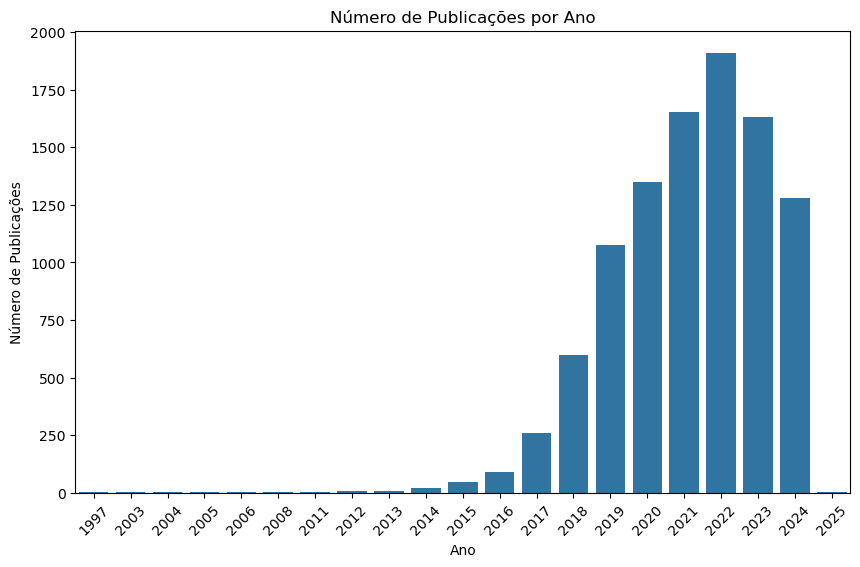

In [69]:
publicacoes_por_ano = df['Publication Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=publicacoes_por_ano.index, y=publicacoes_por_ano.values)
plt.title('Número de Publicações por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.xticks(rotation=45)
plt.show()

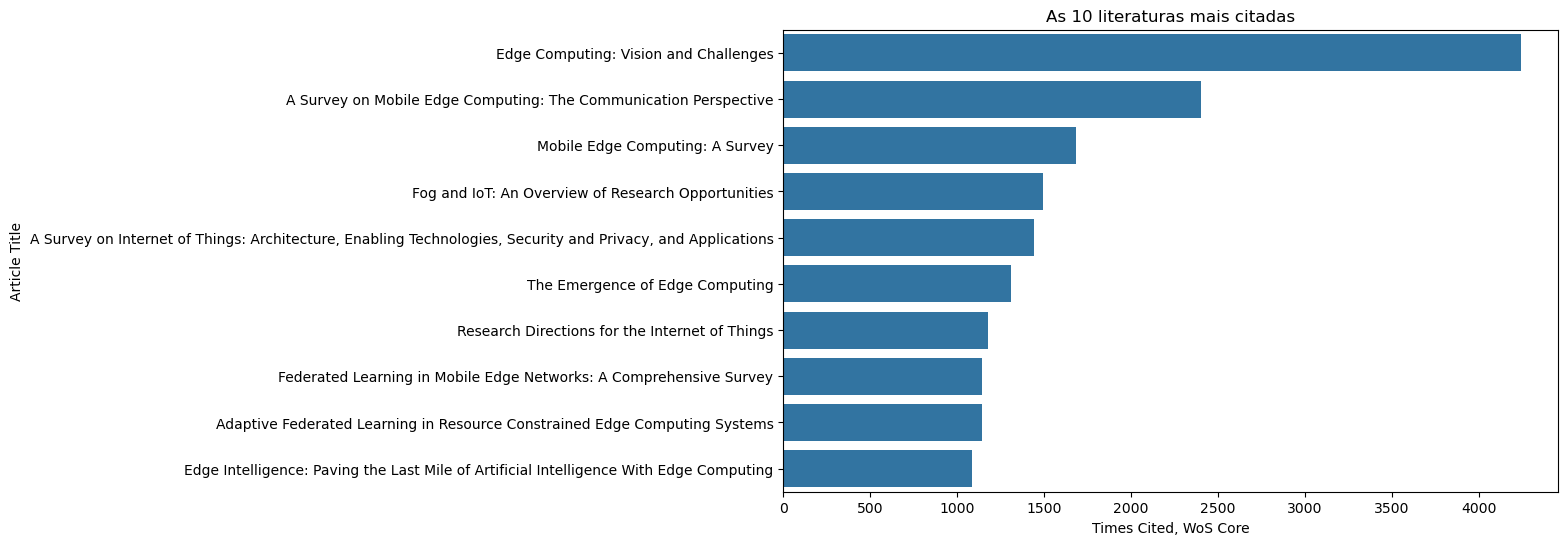

In [70]:
# 1. As 10 literaturas mais citadas

literature_data = df[['Article Title', 'Times Cited, WoS Core']].sort_values('Times Cited, WoS Core', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='Times Cited, WoS Core', y='Article Title', data=literature_data)
plt.title('As 10 literaturas mais citadas')
plt.show() 

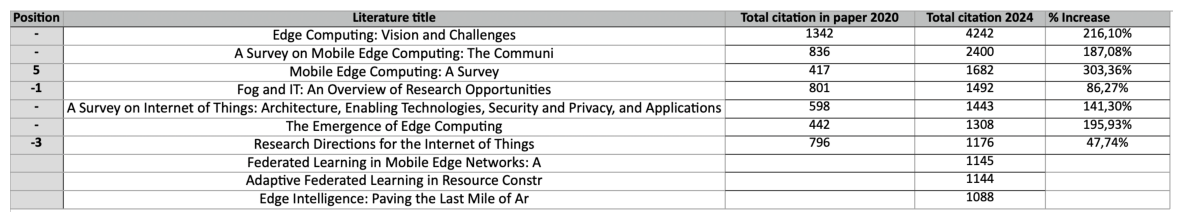

In [71]:
img = mpimg.imread('imgs/the-top-10-most-cited-literatures-2024.png')

plt.figure(figsize=(15, 8))

plt.imshow(img)
plt.axis('off')   
plt.show()

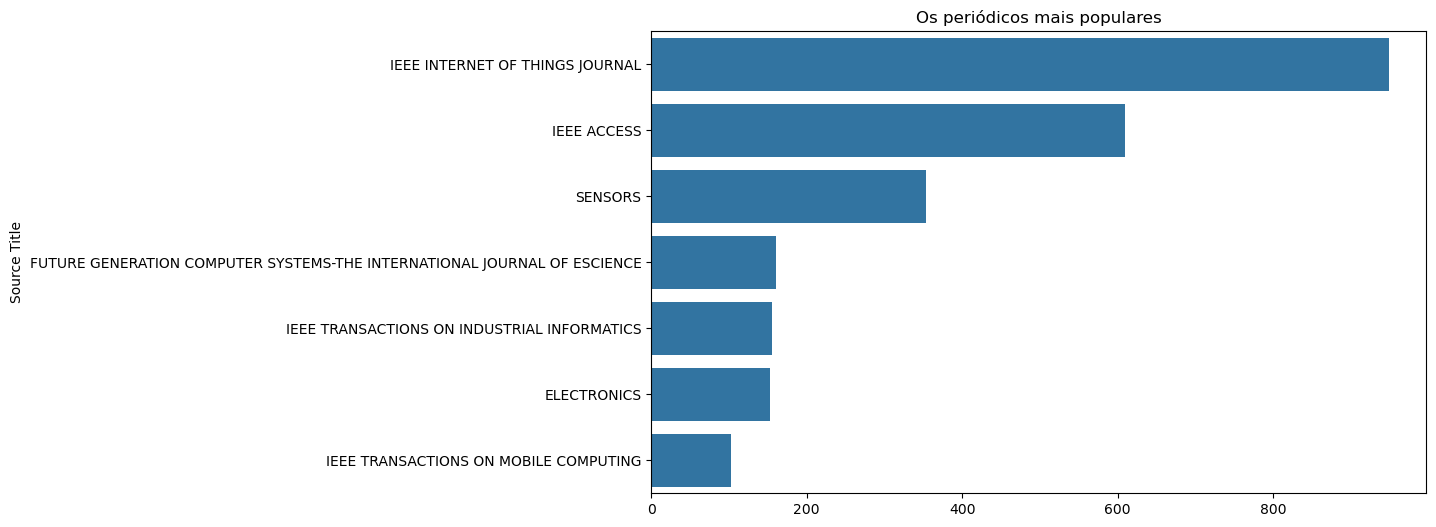

In [72]:
# 2. Os periódicos mais populares

journal_data = df['Source Title'].value_counts().head(7)
plt.figure(figsize=(10,6))
sns.barplot(x=journal_data.values, y=journal_data.index)
plt.title('Os periódicos mais populares')
plt.show() 

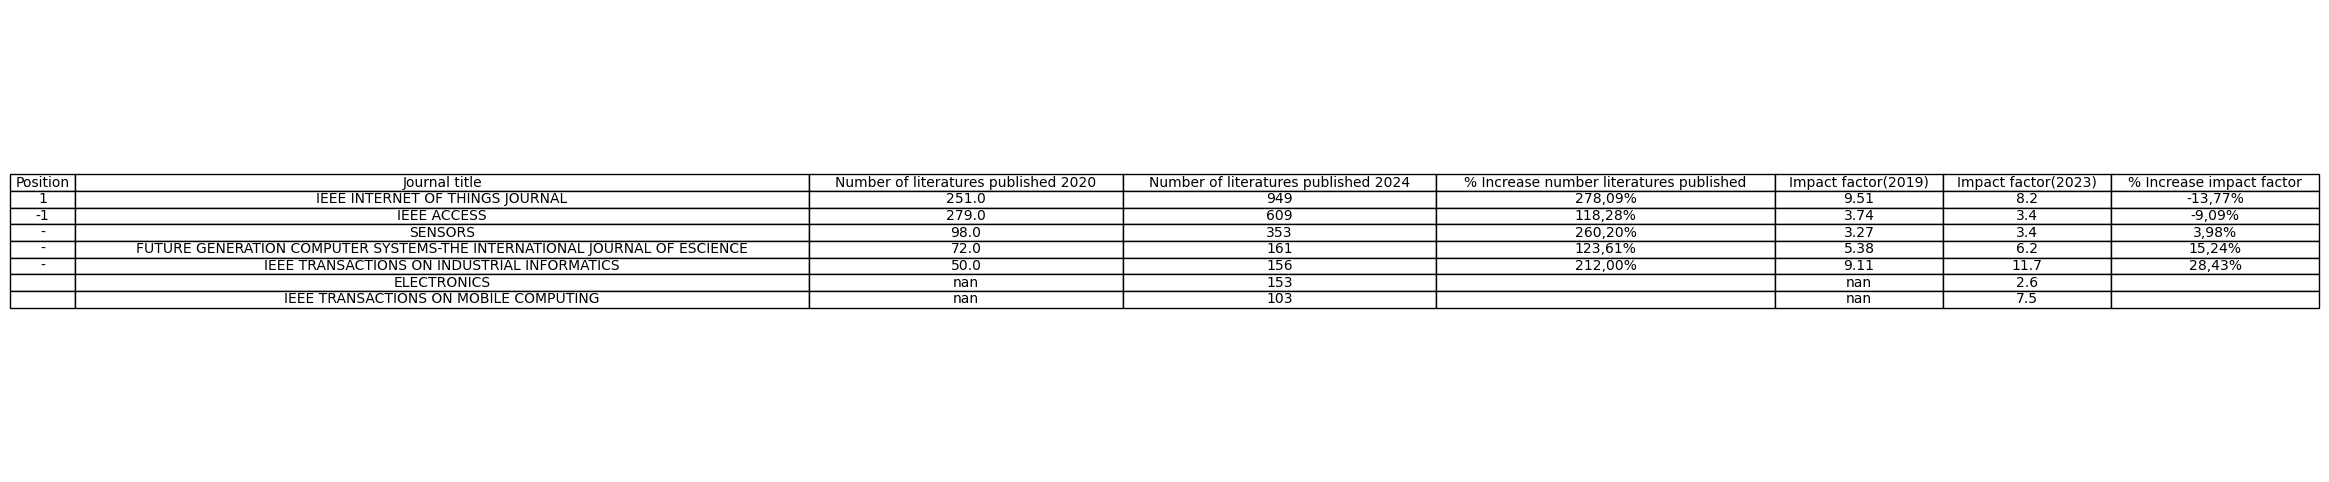

In [73]:

data = {
    'Position': [1, -1, '-', '-', '-', '', ''],
    'Journal title': [
        'IEEE INTERNET OF THINGS JOURNAL',
        'IEEE ACCESS',
        'SENSORS',
        'FUTURE GENERATION COMPUTER SYSTEMS-THE INTERNATIONAL JOURNAL OF ESCIENCE',
        'IEEE TRANSACTIONS ON INDUSTRIAL INFORMATICS',
        'ELECTRONICS',
        'IEEE TRANSACTIONS ON MOBILE COMPUTING'
    ],
    'Number of literatures published 2020': [251, 279, 98, 72, 50, None, None],
    'Number of literatures published 2024': [949, 609, 353, 161, 156, 153, 103],
    '% Increase number literatures published': ['278,09%', '118,28%', '260,20%', '123,61%', '212,00%', None, None],
    'Impact factor(2019)': [9.51, 3.74, 3.27, 5.38, 9.11, None, None],
    'Impact factor(2023)': [8.2, 3.4, 3.4, 6.2, 11.7, 2.6, 7.5],
    '% Increase impact factor': ['-13,77%', '-9,09%', '3,98%', '15,24%', '28,43%', None, None]
}

tmp_table = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(12, 6)) 
ax.axis('tight')
ax.axis('off')

the_table = ax.table(cellText=tmp_table.values, colLabels=tmp_table.columns, cellLoc='center', loc='center')

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

for i, column in enumerate(tmp_table.columns):
    max_length = max(tmp_table[column].astype(str).map(len).max(), len(column)) 
    the_table.auto_set_column_width([i])  
    the_table[i, 0].set_width(max_length * 0.015) 

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


       Author  Publication Count
0    Zhang, Y                 85
1     Chen, Y                 77
2     Wang, J                 69
3     Chen, X                 64
4    Zhang, J                 61
5  Guizani, M                 61
6       Li, J                 59
7     Wang, Y                 56
8      Liu, Y                 55
9       Wu, J                 52


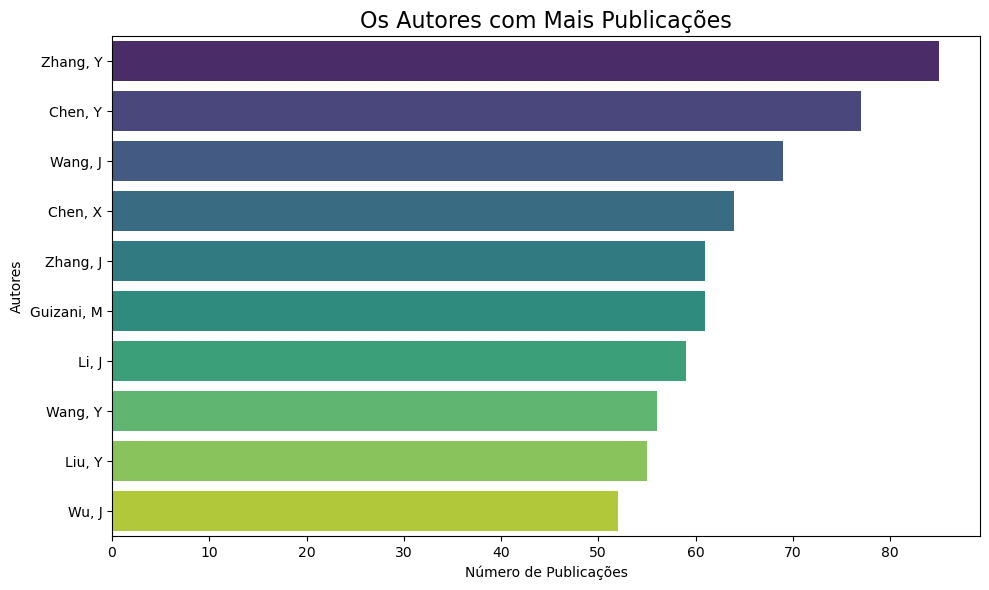

In [74]:
df_temp = df.copy()

df_temp['Authors'] = df_temp['Authors'].str.split('; ')
df_temp = df_temp.explode('Authors')

df_unique = df_temp.drop_duplicates(subset=['Authors', 'Article Title'])

author_data = df_unique['Authors'].value_counts().head(10)

author_df = author_data.reset_index()
author_df.columns = ['Author', 'Publication Count']

print(author_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Publication Count', y='Author', data=author_df, hue='Author', palette='viridis', dodge=False)
plt.title('Os Autores com Mais Publicações', fontsize=16)
plt.xlabel('Número de Publicações')
plt.ylabel('Autores')
plt.legend().set_visible(False) 
plt.tight_layout()
plt.show()

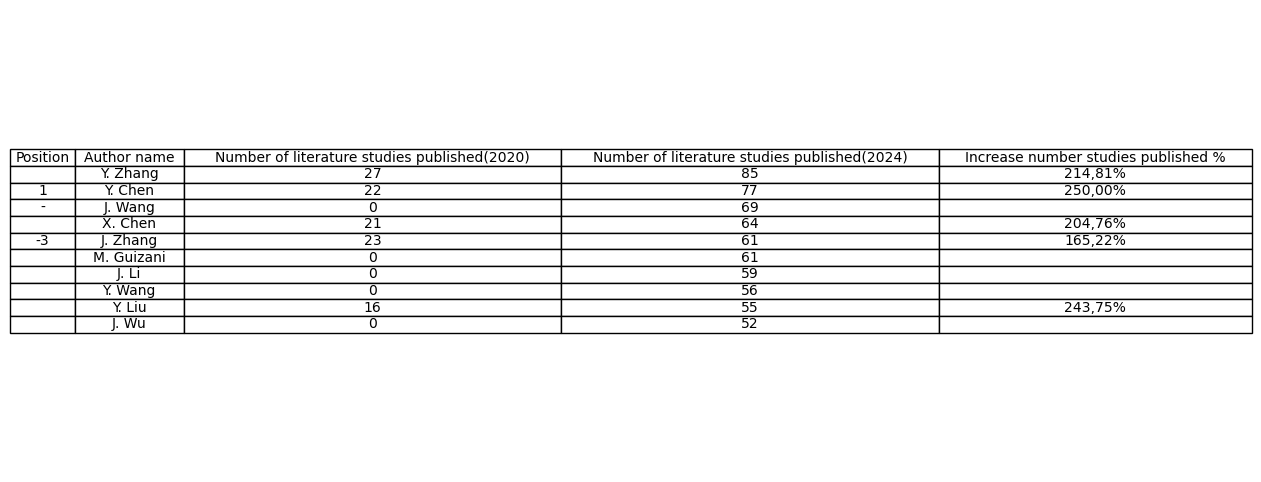

In [75]:
data = {
    'Position': ['', '1', '-', '', '-3', '', '', '', '', ''],
    'Author name': [
        'Y. Zhang', 
        'Y. Chen', 
        'J. Wang', 
        'X. Chen', 
        'J. Zhang', 
        'M. Guizani', 
        'J. Li', 
        'Y. Wang', 
        'Y. Liu',
        'J. Wu'
    ],
    'Number of literature studies published(2020)': [27, 22, 0, 21, 23, 0, 0, 0, 16, 0],
    'Number of literature studies published(2024)': [85, 77, 69, 64, 61, 61, 59, 56, 55, 52],
    'Increase number studies published %': ['214,81%', '250,00%', None, '204,76%', '165,22%', None, None, None, '243,75%', None]
}

max_length = max(len(data['Position']),
                 len(data['Author name']),
                 len(data['Number of literature studies published(2020)']),
                 len(data['Number of literature studies published(2024)']),
                 len(data['Increase number studies published %']))

for key in data.keys():
    while len(data[key]) < max_length:
        data[key].append(None)

tmp_table = pd.DataFrame(data)

tmp_table['Number of literature studies published(2020)'] = tmp_table['Number of literature studies published(2020)'].astype(int)
tmp_table['Number of literature studies published(2024)'] = tmp_table['Number of literature studies published(2024)'].astype(int)

fig, ax = plt.subplots(figsize=(12, 6)) 
ax.axis('tight')
ax.axis('off')

the_table = ax.table(cellText=tmp_table.values, colLabels=tmp_table.columns, cellLoc='center', loc='center')

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

for i, column in enumerate(tmp_table.columns):
    max_length = max(tmp_table[column].astype(str).map(len).max(), len(column)) 
    the_table.auto_set_column_width([i])  
    the_table[i, 0].set_width(max_length * 0.015) 

plt.show()


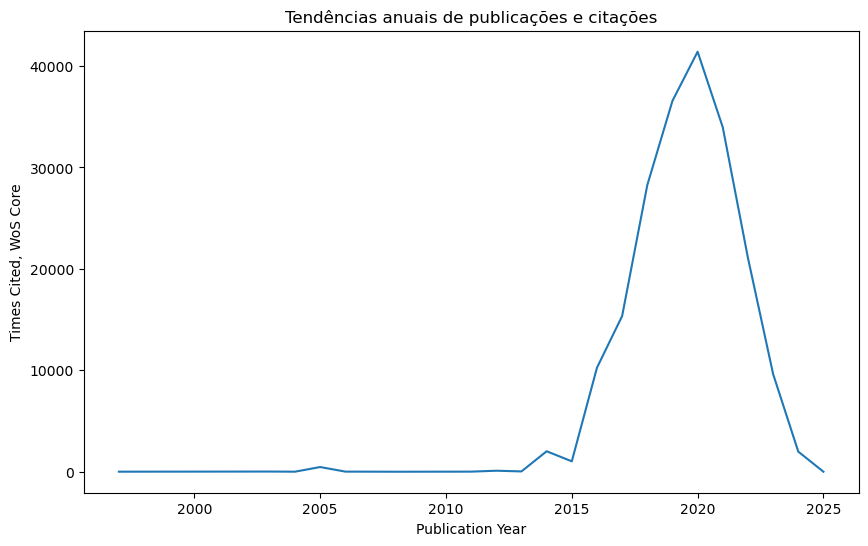

In [76]:
# 4. Tendências anuais de publicações e citações
yearly_trend = df.groupby('Publication Year')['Times Cited, WoS Core'].sum().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x='Publication Year', y='Times Cited, WoS Core', data=yearly_trend)
plt.title('Tendências anuais de publicações e citações')
plt.show() 

Affiliations
Beijing University of Posts & Telecommunications     59
University of Messina                                23
Technische Universitat Wien                          22
National University of Defense Technology - China    20
Beijing University of Technology                     18
University of Glasgow                                17
Shanghai Jiao Tong University                        16
University of Bologna                                16
Sun Yat Sen University                               14
Xidian University                                    13
Name: count, dtype: int64


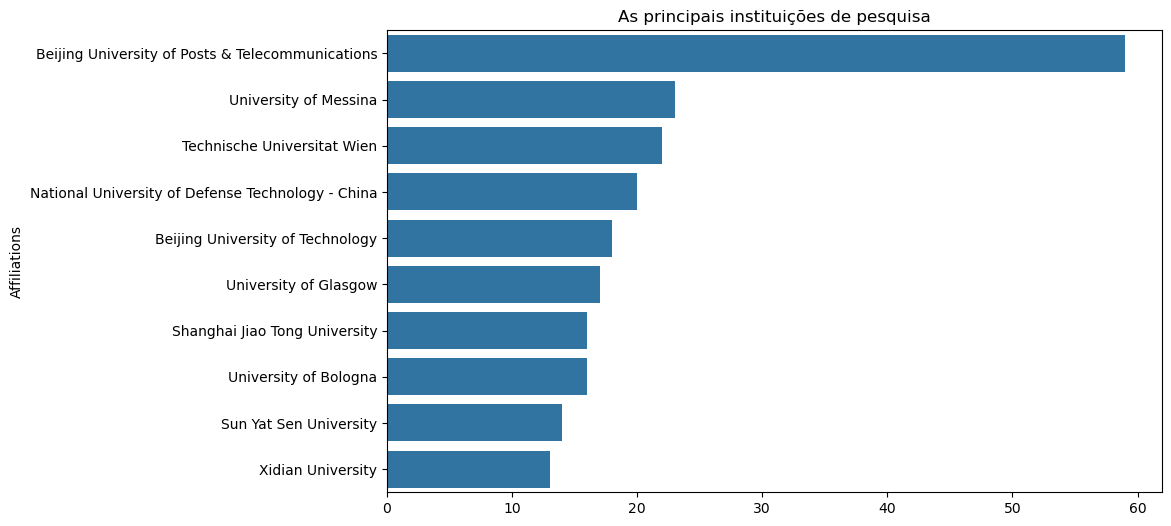

In [86]:
# 5. As principais instituições de pesquisa
df_temp = pd.read_excel('datasets/artigos_processado.xlsx', engine='openpyxl')


institutions_data = df_temp['Affiliations'].value_counts().head(10)
print(institutions_data)
plt.figure(figsize=(10,6))
sns.barplot(x=institutions_data.values, y=institutions_data.index)
plt.title('As principais instituições de pesquisa')
plt.show()

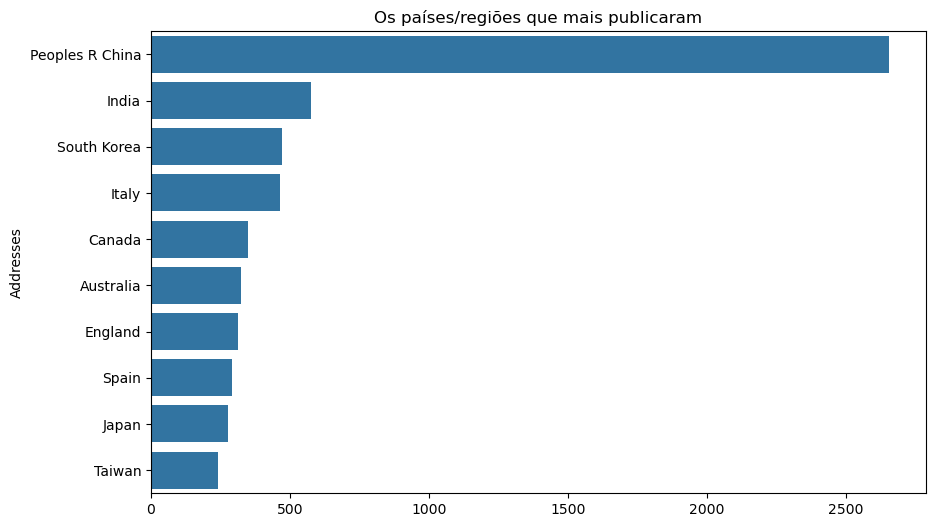

In [90]:
# 6. Os países/regiões que mais publicaram
countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip()).value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=countries_data.values, y=countries_data.index)
plt.title('Os países/regiões que mais publicaram')
plt.show()

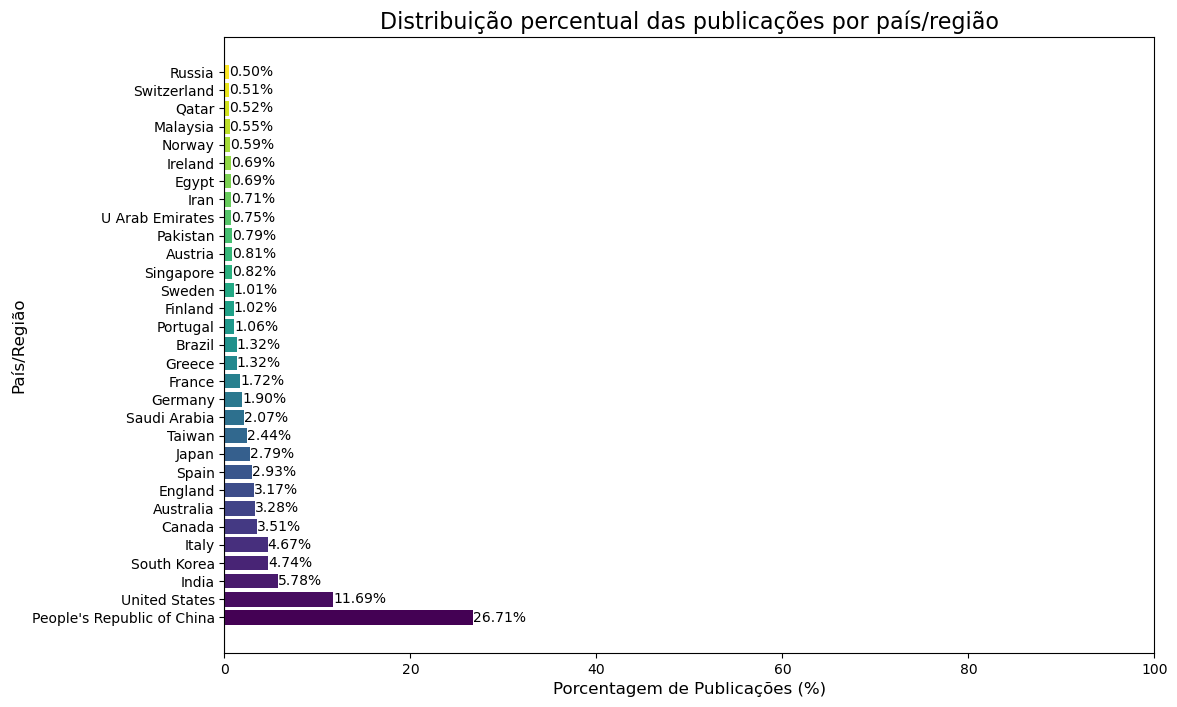

In [11]:
countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip()).value_counts()

def clean_country_name(name):
    name = name.strip()
    if 'USA' in name:
        return 'United States'
    if 'R China' in name:
        return 'People\'s Republic of China'
    return name

countries_data.index = countries_data.index.map(clean_country_name)

countries_data = countries_data.groupby(countries_data.index).sum()

total_publications = countries_data.sum()
countries_percentage = (countries_data / total_publications) * 100

countries_percentage = countries_percentage[countries_percentage > 0.5]

countries_percentage = countries_percentage.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(countries_percentage))) 
bars = plt.barh(countries_percentage.index, countries_percentage.values, color=colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', va='center')

plt.title('Distribuição percentual das publicações por país/região', fontsize=16)
plt.xlabel('Porcentagem de Publicações (%)', fontsize=12)
plt.ylabel('País/Região', fontsize=12)
plt.xlim(0, 100)  
plt.axvline(0, color='grey', linewidth=0.8) 
plt.show()


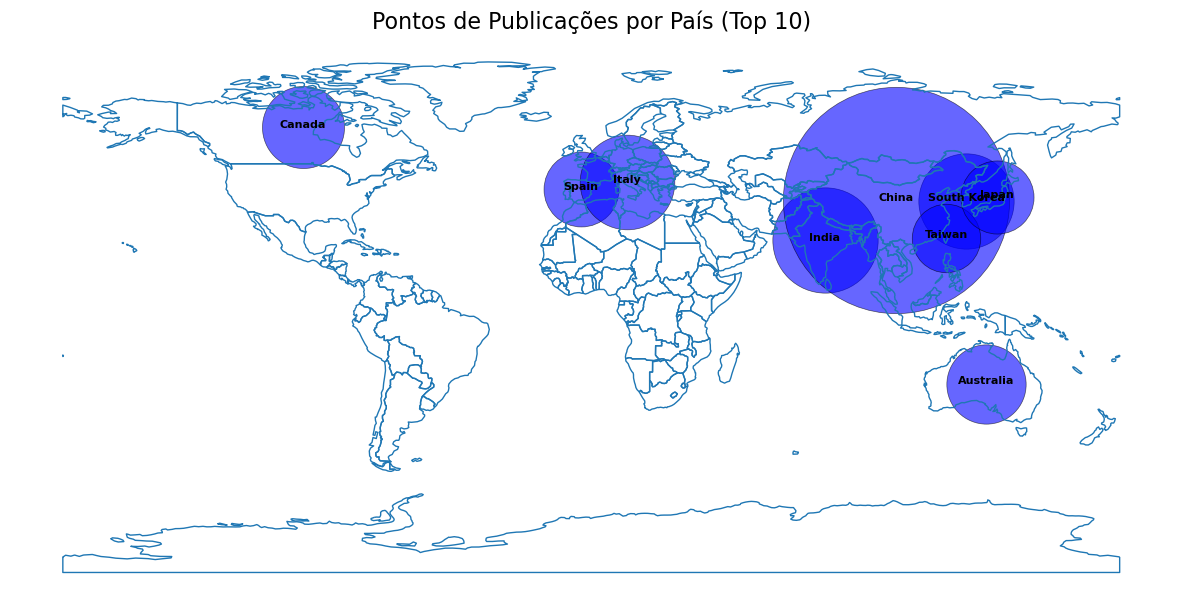

In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from fuzzywuzzy import process

world = gpd.read_file('datasets/map/ne_110m_admin_0_countries.shp')

countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip()).value_counts()
countries_df = pd.DataFrame(countries_data).reset_index()
countries_df.columns = ['Country', 'Publication Count']

top_countries_df = countries_df.nlargest(10, 'Publication Count')

world['ADMIN'] = world['ADMIN'].str.strip().str.title()

def get_best_match(country_name, choices):
    if not country_name:  
        return None
    match, score = process.extractOne(country_name, choices)
    return match if score >= 80 else None  

geo_countries = world['ADMIN'].unique()

top_countries_df['Country'] = top_countries_df['Country'].apply(lambda x: get_best_match(x, geo_countries))

top_countries_df = top_countries_df.dropna(subset=['Country'])

merged = world.merge(top_countries_df, how="left", left_on="ADMIN", right_on="Country")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, linewidth=1)

for idx, row in merged.iterrows():
    if row['Publication Count'] > 0:
        ax.scatter(*row.geometry.centroid.coords[0], 
                   s=row['Publication Count'] * 10, 
                   alpha=0.6, color='blue', edgecolor='k', linewidth=0.5)
        ax.annotate(text=row['Country'], 
                    xy=row.geometry.centroid.coords[0], 
                    ha='center', fontsize=8, color='black', weight='bold')

plt.title('Pontos de Publicações por País (Top 10)', fontsize=16)
plt.axis('off') 
plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
from concurrent.futures import ThreadPoolExecutor

def count_cooccurrences(keywords):
    cooccurrence = Counter()
    for pair in combinations(set(keywords), 2):
        cooccurrence[pair] += 1
    return cooccurrence

df = pd.read_excel('datasets/artigos_processado.xlsx', engine='openpyxl')

hotspot_data = df['Author Keywords'].str.split(';').explode().str.strip().str.lower()

hotspot_data = hotspot_data.dropna()
hotspot_data = hotspot_data[hotspot_data != '']

cooccurrence = Counter()

with ThreadPoolExecutor() as executor:
    results = executor.map(count_cooccurrences, 
                            hotspot_data.groupby(hotspot_data.index).agg(lambda x: list(x)))
    
    for result in results:
        cooccurrence.update(result)

G = nx.Graph()

for (word1, word2), count in cooccurrence.items():
    G.add_edge(word1, word2, weight=count)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)
edges = G.edges(data=True)

nx.draw_networkx_nodes(G, pos, node_size=700)

nx.draw_networkx_edges(G, pos, width=[edge[2]['weight'] for edge in edges], alpha=0.5)

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title('Keywords Co-Occurrence Network', fontsize=16)
plt.axis('off')  
plt.show()


In [ ]:

co_citations = []

for index, row in df.iterrows():
    title = row['Article Title']
    
    if pd.notna(row['Cited References']):
        cited_refs = row['Cited References'].split(';')  
        
        for cited in cited_refs:
            co_citations.append((title.strip(), cited.strip()))

co_citation_df = pd.DataFrame(co_citations, columns=['source', 'target'])

co_citation_counts = co_citation_df.value_counts().reset_index(name='weight')


G = nx.from_pandas_edgelist(co_citation_counts, source='source', target='target', edge_attr='weight', create_using=nx.Graph())

pos = nx.spring_layout(G, k=0.5, iterations=50)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.7)

nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] * 0.1 for u, v in G.edges()], alpha=0.5, edge_color='gray')

nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.title('Rede de Co-citação de Artigos', fontsize=16)
plt.axis('off') 
plt.tight_layout()

plt.show()
